Setup enviroment

In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu121


In [3]:
!pip install -q dgl

In [4]:
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric import nn
import torch_geometric.transforms as T

In [5]:
import json
import pandas as pd
import numpy as np
import random
import dgl
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn

/tmp/ipykernel_3778411/4213285088.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load node2id dictionary

In [8]:
os.path.isdir("/gpfs/gibbs/pi/gerstein/yc774/project/miRGD/graph")

True

In [9]:
#open files
proj_dir = os.path.join("/gpfs/gibbs/pi/gerstein/yc774/project/miRGD/graph")
f = open(os.path.join(proj_dir,"node2id.json"))
node2id = json.load(f)

f = open(os.path.join(proj_dir,"id2node.json"))
id2node = json.load(f)

In [10]:
relation = ["mm","dd","gg","md","mg","dg"]

edge_index = {}
for rel in relation:
  pth = os.path.join(proj_dir,"{}_edge.csv".format(rel))
  edge_df = pd.read_csv(pth)
  edge_list = np.transpose(edge_df.values)
  edge_index[rel] = torch.tensor(edge_list).long()

In [11]:
edge_index

{'mm': tensor([[ 898,  898,  898,  ...,  694,  482,  482],
         [ 841, 1069,  541,  ...,  953, 1011,  147]]),
 'dd': tensor([[1175, 1175, 1175,  ..., 1134, 1134, 1134],
         [1180, 1144, 1208,  ..., 1168, 1141, 1139]]),
 'gg': tensor([[2147, 2147, 2147,  ..., 6556, 8910, 5385],
         [8388, 7092, 9807,  ..., 1735, 1735, 1735]]),
 'md': tensor([[ 898,  898,  898,  ...,  270,  946,  250],
         [1193, 1180, 1214,  ..., 1191, 1213, 1213]]),
 'mg': tensor([[  32,  832,  832,  ...,  589,  589,  100],
         [5215, 7835, 7835,  ..., 5135, 9328, 4016]]),
 'dg': tensor([[5925, 5925, 4194,  ..., 7342, 5467, 5467],
         [1183, 1153, 1153,  ..., 1204, 1131, 1148]])}

In [12]:
miRNA_id = list(range(1109))
disease_id = list(range(1109,1222))
gene_id = list(range(1222,10532))


# convert old unique id to seperete set of new ID
disease_new_id_dict = {}
new_id = 0
for old_id in disease_id:
  disease_new_id_dict[old_id] = new_id
  new_id+=1

gene_new_id_dict = {}
new_id = 0
for old_id in gene_id:
  gene_new_id_dict[old_id] = new_id
  new_id+=1



new_edge_index = {}
new_edge_index['mm'] = edge_index['mm']

new_edge_index['dd'] = torch.tensor([
  [disease_new_id_dict[old_id] for old_id in edge_index['dd'][0].numpy()],
  [disease_new_id_dict[old_id] for old_id in edge_index['dd'][1].numpy()],
])
new_edge_index['gg'] = torch.tensor([
  [gene_new_id_dict[old_id] for old_id in edge_index['gg'][0].numpy()],
  [gene_new_id_dict[old_id] for old_id in edge_index['gg'][1].numpy()],
])
new_edge_index['md'] = torch.tensor([
  edge_index['md'][0].numpy(),
  [disease_new_id_dict[old_id] for old_id in edge_index['md'][1].numpy()],
])

new_edge_index['mg'] = torch.tensor([
  edge_index['mg'][0].numpy(),
  [gene_new_id_dict[old_id] for old_id in edge_index['mg'][1].numpy()]
])

new_edge_index['gd'] = torch.tensor([
  [gene_new_id_dict[old_id] for old_id in edge_index['dg'][0].numpy()],
  [disease_new_id_dict[old_id] for old_id in edge_index['dg'][1].numpy()],
])


/tmp/ipykernel_3778411/2437488178.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  new_edge_index['md'] = torch.tensor([


In [13]:
new_edge_index

{'mm': tensor([[ 898,  898,  898,  ...,  694,  482,  482],
         [ 841, 1069,  541,  ...,  953, 1011,  147]]),
 'dd': tensor([[66, 66, 66,  ..., 25, 25, 25],
         [71, 35, 99,  ..., 59, 32, 30]]),
 'gg': tensor([[ 925,  925,  925,  ..., 5334, 7688, 4163],
         [7166, 5870, 8585,  ...,  513,  513,  513]]),
 'md': tensor([[898, 898, 898,  ..., 270, 946, 250],
         [ 84,  71, 105,  ...,  82, 104, 104]]),
 'mg': tensor([[  32,  832,  832,  ...,  589,  589,  100],
         [3993, 6613, 6613,  ..., 3913, 8106, 2794]]),
 'gd': tensor([[4703, 4703, 2972,  ..., 6120, 4245, 4245],
         [  74,   44,   44,  ...,   95,   22,   39]])}

In [14]:

n_hetero_features = 10

hetero_graph = dgl.heterograph({
    ('miRNA', 'similar_to', 'miRNA'): (new_edge_index['mm'][0], new_edge_index['mm'][1]),
    ('gene', 'similar_to', 'gene'): (new_edge_index['gg'][0], new_edge_index['gg'][1]),
    ('disease', 'similar_to', 'disease'): (new_edge_index['dd'][0], new_edge_index['dd'][1]),
    ('miRNA', 'target_to', 'gene'): (new_edge_index['mg'][0], new_edge_index['mg'][1]),
    ('miRNA', 'associate_with', 'disease'): (new_edge_index['md'][0], new_edge_index['md'][1]),
    ('gene', 'related_to', 'disease'): (new_edge_index['gd'][0], new_edge_index['gd'][1])})

n_miRNA = hetero_graph.num_nodes('miRNA')
n_gene = hetero_graph.num_nodes('gene')
n_disease= hetero_graph.num_nodes('disease')

hetero_graph.nodes['miRNA'].data['feature'] = torch.randn(n_miRNA, n_hetero_features)
hetero_graph.nodes['gene'].data['feature'] = torch.randn(n_gene, n_hetero_features)
hetero_graph.nodes['disease'].data['feature'] = torch.randn(n_disease, n_hetero_features)

hetero_graph

Graph(num_nodes={'disease': 113, 'gene': 9308, 'miRNA': 1109},
      num_edges={('disease', 'similar_to', 'disease'): 4863, ('gene', 'related_to', 'disease'): 9596, ('gene', 'similar_to', 'gene'): 519568, ('miRNA', 'associate_with', 'disease'): 3999, ('miRNA', 'similar_to', 'miRNA'): 346623, ('miRNA', 'target_to', 'gene'): 25405},
      metagraph=[('disease', 'disease', 'similar_to'), ('gene', 'disease', 'related_to'), ('gene', 'gene', 'similar_to'), ('miRNA', 'disease', 'associate_with'), ('miRNA', 'miRNA', 'similar_to'), ('miRNA', 'gene', 'target_to')])

In [15]:
hetero_graph.nodes['miRNA']

NodeSpace(data={'feature': tensor([[ 0.3349,  0.5735,  1.1363,  ...,  0.5029, -0.4204,  0.1587],
        [ 0.1189, -0.7840,  1.4562,  ..., -0.7830,  1.1746,  0.5683],
        [ 0.1822, -0.4866, -1.2988,  ..., -0.0552,  2.3712, -0.8149],
        ...,
        [-1.4767, -0.2339,  2.5727,  ..., -0.4269, -0.4500, -0.9414],
        [ 0.5236, -1.0844, -0.8403,  ..., -0.0344,  0.0825,  1.8169],
        [-0.1756,  1.5667,  1.4037,  ...,  0.9257, -0.2541, -0.6718]])})

Link Prediction - Random Feature

In [16]:
class HeteroGAT_3layer(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names, num_heads=4):
        super().__init__()

        # First GAT layer for each relation
        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GATConv(in_feats, hid_feats, num_heads=num_heads)
            for rel in rel_names}, aggregate='mean')

        # Adjust in_feats for second layer considering num_heads
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GATConv(hid_feats * num_heads, out_feats, num_heads=num_heads)
            for rel in rel_names}, aggregate='mean')
        
    def forward(self, graph, inputs, mask=None):
        # First layer
        h = self.conv1(graph, inputs)
        # Apply non-linearity and concatenate heads
        h = {k: F.relu(v).view(v.shape[0], -1) for k, v in h.items()}

        # Second layer
        h = self.conv2(graph, h)
        # Concatenate heads for output layer as well
        h = {k: v.view(v.shape[0], -1) for k, v in h.items()}

        return h
        
def construct_negative_graph(graph, k, etype):
    utype, _, vtype = etype
    src, dst = graph.edges(etype=etype)
    neg_src = src.repeat_interleave(k)
    neg_dst = torch.randint(0, graph.num_nodes(vtype), (len(src) * k,))
    return dgl.heterograph(
        {etype: (neg_src, neg_dst)},
        num_nodes_dict={ntype: graph.num_nodes(ntype) for ntype in graph.ntypes})

class HeteroDotProductPredictor(nn.Module):
    def forward(self, graph, h, etype):
        # h contains the node representations for each node type computed from
        # the GNN defined in the previous section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)
            return graph.edges[etype].data['score']

class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = HeteroGAT_3layer(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroDotProductPredictor()
    def forward(self, g, neg_g, x, etype, pos_train_mask):
        h = self.sage(g, x, pos_train_mask)
        return self.pred(g, h, etype), self.pred(neg_g, h, etype)


n_hetero_features = 32
n_hidden = 64
n_output = 32
hetero_graph = dgl.heterograph({
    ('miRNA', 'similar_to', 'miRNA'): (new_edge_index['mm'][0], new_edge_index['mm'][1]),
    ('gene', 'similar_to', 'gene'): (new_edge_index['gg'][0], new_edge_index['gg'][1]),
    ('disease', 'similar_to', 'disease'): (new_edge_index['dd'][0], new_edge_index['dd'][1]),
    ('miRNA', 'target_to', 'gene'): (new_edge_index['mg'][0], new_edge_index['mg'][1]),
    ('miRNA', 'associate_with', 'disease'): (new_edge_index['md'][0], new_edge_index['md'][1]),
    ('gene', 'related_to', 'disease'): (new_edge_index['gd'][0], new_edge_index['gd'][1])})

n_miRNA = hetero_graph.num_nodes('miRNA')
n_gene = hetero_graph.num_nodes('gene')
n_disease= hetero_graph.num_nodes('disease')

hetero_graph.nodes['miRNA'].data['feature'] = torch.randn(n_miRNA, n_hetero_features)
hetero_graph.nodes['gene'].data['feature'] = torch.randn(n_gene, n_hetero_features)
hetero_graph.nodes['disease'].data['feature'] = torch.randn(n_disease, n_hetero_features)

def compute_loss_with_mask(pos_score, neg_score):
    # Margin loss
    n_edges = pos_score.shape[0]
    return (1 - pos_score +  neg_score.view(n_edges, -1)).clamp(min=0).mean()


k = 5
model = Model(n_hetero_features, n_hidden, n_output, hetero_graph.etypes)
miRNA_feats = hetero_graph.nodes['miRNA'].data['feature']
gene_feats = hetero_graph.nodes['gene'].data['feature']
disease_feats = hetero_graph.nodes['disease'].data['feature']
node_features = {'miRNA': miRNA_feats, 'gene': gene_feats, 'disease':disease_feats}

num_target_edge = hetero_graph['associate_with'].num_edges()
pos_train_mask = (torch.rand(num_target_edge, 1) > 0.3).float()

pos_train_index = torch.tensor(np.where(pos_train_mask == 1)[0])
pos_valid_index = torch.tensor(np.where(pos_train_mask == 0)[0])

num_epoch = 200

loss_fn = nn.BCEWithLogitsLoss()

opt = torch.optim.Adam(model.parameters())
best_loss = float('inf')
patience = 10  # Set your patience level
counter = 0

train_loss_accu = []
valid_loss_accu = []
train_accuracy_accu = []
valid_accuracy_accu = []

for epoch in range(num_epoch):
    negative_graph_train = construct_negative_graph(hetero_graph, k, ('miRNA', 'associate_with', 'disease'))
    pos_score, neg_score = model(hetero_graph, negative_graph_train, node_features, ('miRNA', 'associate_with', 'disease'), pos_train_mask)
    
    perm = torch.randperm(neg_score.size(0))
    neg_train_index = perm[:int(5*sum(pos_train_mask))]
    neg_valid_index = perm[int(5*sum(pos_train_mask)):]

    loss = compute_loss_with_mask(torch.index_select(pos_score, 0, pos_train_index), torch.index_select(neg_score, 0, neg_train_index))

    predict = torch.cat((torch.index_select(pos_score, 0, pos_train_index), torch.index_select(neg_score, 0, neg_train_index)), 0)
    target = torch.tensor([1]*torch.index_select(pos_score, 0, pos_train_index).shape[0] + [0]*torch.index_select(neg_score, 0, neg_train_index).shape[0]).unsqueeze(1)
    
    loss = loss_fn(predict, target.float())

    opt.zero_grad()
    loss.backward()
    opt.step()

    predict = torch.cat((torch.index_select(pos_score, 0, pos_valid_index), torch.index_select(neg_score, 0, neg_valid_index)), 0)
    target = torch.tensor([1]*torch.index_select(pos_score, 0, pos_valid_index).shape[0] + [0]*torch.index_select(neg_score, 0, neg_valid_index).shape[0]).unsqueeze(1)
    valid_loss = loss_fn(predict, target.float())

    train_loss_accu.append(loss.item())
    valid_loss_accu.append(valid_loss.item())

    accu_pos = (torch.index_select(pos_score, 0, pos_valid_index) > 0)
    accu_neg = (torch.index_select(neg_score, 0, neg_valid_index) < 0)
    valid_accu = (sum(accu_pos) + sum(accu_neg)) / (len(accu_pos) + len(accu_neg))

    accu_pos = (torch.index_select(pos_score, 0, pos_train_index) > 0)
    accu_neg = (torch.index_select(neg_score, 0, neg_train_index) < 0)
    train_accu = (sum(accu_pos) + sum(accu_neg)) / (len(accu_pos) + len(accu_neg))

    train_accuracy_accu.append(train_accu)
    valid_accuracy_accu.append(valid_accu)

    print("epoch: ", epoch, " train loss: ", loss.item(), " valid loss: ", valid_loss.item(), " train_accuracy: ", train_accu, " valid accuracy: ", valid_accu)

    # Early stopping check
    if valid_loss.item() < best_loss:
        best_loss = valid_loss.item()
        counter = 0  # reset the counter if validation loss improves
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break


    print("epoch: ", epoch, " train loss: ", loss.item(), " valid loss: ",valid_loss.item(), " train_accuracy: ",train_accu," valid accuracy: ",valid_accu)


epoch:  0  train loss:  0.7510654926300049  valid loss:  0.7527458071708679  train_accuracy:  tensor([0.1523])  valid accuracy:  tensor([0.1514])
epoch:  0  train loss:  0.7510654926300049  valid loss:  0.7527458071708679  train_accuracy:  tensor([0.1523])  valid accuracy:  tensor([0.1514])
epoch:  1  train loss:  0.7024760246276855  valid loss:  0.7034716606140137  train_accuracy:  tensor([0.4527])  valid accuracy:  tensor([0.4543])
epoch:  1  train loss:  0.7024760246276855  valid loss:  0.7034716606140137  train_accuracy:  tensor([0.4527])  valid accuracy:  tensor([0.4543])
epoch:  2  train loss:  0.669343113899231  valid loss:  0.6688662767410278  train_accuracy:  tensor([0.8169])  valid accuracy:  tensor([0.8153])
epoch:  2  train loss:  0.669343113899231  valid loss:  0.6688662767410278  train_accuracy:  tensor([0.8169])  valid accuracy:  tensor([0.8153])
epoch:  3  train loss:  0.642064094543457  valid loss:  0.6415894031524658  train_accuracy:  tensor([0.8260])  valid accuracy:

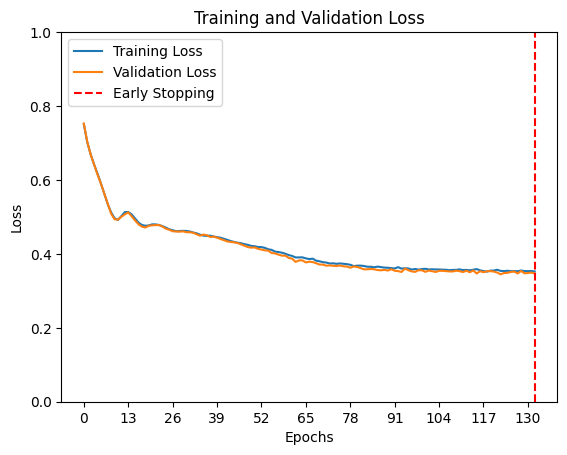

In [17]:
epochs = range(len(train_loss_accu))

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss_accu, label='Training Loss')
plt.plot(epochs, valid_loss_accu, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations and limits
# Adjust the xticks if needed, based on the actual number of epochs completed
plt.xticks(range(0, len(train_loss_accu), max(1, len(train_loss_accu) // 10)))
plt.ylim(ymax=1, ymin=0)

# Mark the point of early stopping
early_stopping_epoch = len(train_loss_accu) - 1  # Last index is the stopping point
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')

# Display the plot
plt.legend(loc='best')
plt.show()

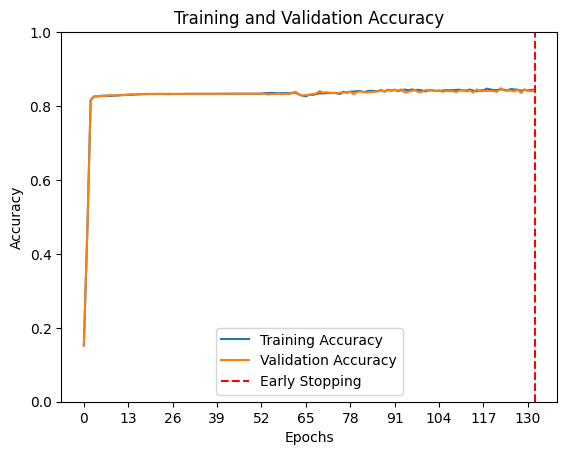

In [18]:
# Generate a sequence of integers to represent the epoch numbers
epochs = range(len(train_accuracy_accu))

# Plot and label the training and validation accuracy values
plt.plot(epochs, train_accuracy_accu, label='Training Accuracy')
plt.plot(epochs, valid_accuracy_accu, label='Validation Accuracy')  # Corrected variable name

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')  # Changed label from 'Loss' to 'Accuracy'

# Set the tick locations and limits
plt.xticks(range(0, len(train_accuracy_accu), max(1, len(train_accuracy_accu) // 10)))
plt.ylim(ymax = 1, ymin = 0)

# Mark the point of early stopping
early_stopping_epoch = len(train_accuracy_accu) - 1  # Assuming the last index is the stopping point
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')

# Display the plot
plt.legend(loc='best')
plt.show()